In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import scipy

import matplotlib.pyplot as plt
from pathlib import Path
from read_data import get_network_df, get_corrs, get_full_df
from numba.core import types
import graph_tool
import numba

from numba import njit
from graph_tool.topology import shortest_distance
import pandas as pd
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types

from transport_problem import OptimParams, DualOracle, HyperParams
from subgd import OracleStacker, ustm_mincost_mcf

In [2]:
graph_type = 2
print("graph type: ", graph_type)
# SMALL GRAPH:

if graph_type == 0:
    net_df = get_network_df(Path('SiouxFalls') / 'SiouxFalls_net.tntp')
    corrs = get_corrs(Path('SiouxFalls') / 'SiouxFalls_trips.tntp')
    people_count = corrs.sum()
    corrs = corrs / people_count
    net_df.capacity /= people_count
    graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

#BERLING GRAPH
if graph_type == 1:
    BIG_CONST_FOR_FAKE_EDGES = 400
    net_df = get_network_df(Path('SiouxFalls') / 'berlin-center_net.tntp')
    corrs = get_corrs(Path('SiouxFalls') / 'berlin-center_trips.tntp')
    net_df.loc[net_df.free_flow_time < 1e-6, "free_flow_time"] = BIG_CONST_FOR_FAKE_EDGES
    people_count = corrs.sum()
    corrs = corrs / people_count
    net_df.capacity /= people_count
    net_df = net_df.rename({"free_flow_time":"fft"}, axis=1)

if graph_type == 2:
    BIG_CONST_FOR_FAKE_EDGES = 40
    net_df = get_network_df(Path('SiouxFalls') / 'ChicagoSketch_net.tntp')
    corrs = get_corrs(Path('SiouxFalls') / 'ChicagoSketch_trips.tntp')
    print(net_df.free_flow_time.max())
    net_df.loc[net_df.free_flow_time < 1e-6, "free_flow_time"] = BIG_CONST_FOR_FAKE_EDGES
    people_count = corrs.sum()
    corrs = corrs / people_count
    net_df.capacity /= people_count
    net_df = net_df.rename({"free_flow_time":"fft"}, axis=1)

graph type:  2
24.92


In [3]:
graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

In [4]:
from transport_problem import HyperParams, DualOracle, OptimParams 
l = np.maximum(np.sum(corrs, axis=1), 1e-6)
w = np.maximum(np.sum(corrs, axis=0), 1e-6)

zones_num = len(l)
sources = np.arange(zones_num)
targets = np.arange(zones_num)

params = HyperParams(gamma=10, mu_pow=0.25, rho=0.15)
oracle = DualOracle(graph, l, w, params, net_df=net_df)
oracle_stacker = OracleStacker(oracle, graph, sources, targets)

# oracle.COUNT_PROCESSES = 6

In [5]:
results = ustm_mincost_mcf(oracle_stacker,  eps_abs=1e-2, eps_cons_abs=1e-3, max_iter=1000, stop_by_crit=True)

y_start:  [40. 40. 40. ...  0.  0.  0.]
first exceeding the limits:  0.08332367807699616
start optimizing
first dual_func:  7.839844329282641e-10


  2%|▏         | 15/1000 [00:05<06:20,  2.59it/s]


SystemError: CPUDispatcher(<function sum_flows_from_tree at 0x7efc3ac2e980>) returned a result with an exception set

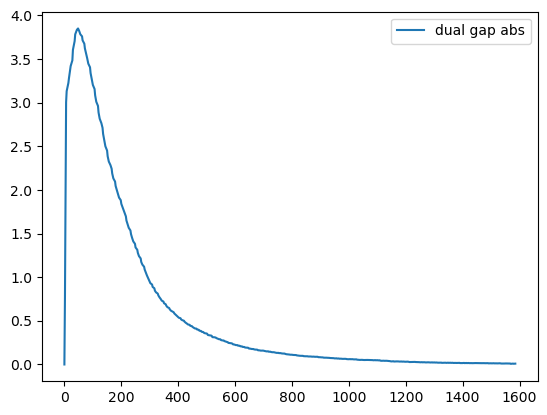

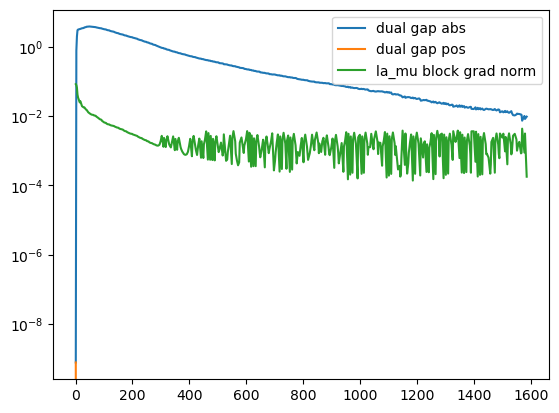

In [22]:
x = results.history_count_calls

plt.plot(x, np.abs(results.history_dual_gap),  label="dual gap abs")
plt.savefig("plot_ustm_dual_gap abs.png")
# plt.yscale("log")
plt.legend()
plt.show()

plt.plot(x, np.abs(results.history_dual_gap),  label="dual gap abs")
plt.plot(x, results.history_dual_gap,  label="dual gap pos")
plt.plot(x, results.history_la_mu_grad_norm, label="la_mu block grad norm")
plt.savefig("plot_ustm_dual_gap.png")
plt.yscale("log")
plt.legend()
plt.show()

# plt.savefig("plot_ustm_la_mu_grad_norm.png")
# plt.yscale("log")
# plt.legend()
# plt.show()


# plt.plot(x, results.history_prime_values, label="history prime function")
# plt.legend()
# plt.show()

# plt.plot(x, results.history_dual_values, label="history dual function")
# plt.legend()
# plt.show()



In [ ]:
# расчет прямой функции
vars = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
_ = oracle_stacker(vars)
print("prime function value: ", oracle_stacker.get_prime_value())